<h1><center>Predicting significant wave height using machine learning</center></h1>

<img src="https://oceanenergy.ie/wp-content/uploads/2020/12/Ocean-Energy-Buoy-2-2-scaled.jpg" alt="Wave buoy image" title="" />

This notebook present code example to predict in the long term the signficant wave height using seq2seq classic architecture

We used the data of the buoy station number <font color=blue>6400045</font>, downloaded from the European marine observation and data network website ("https://www.emodnet-physics.eu/Map/DefaultMap.aspx")


You will need to install the common data manipulation library **(pandas, NumPy)**, **Keras** for the machine learning part, and **Pandas viz** for data visualization

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

import datetime

In [2]:
#load the data
rawdata = pd.read_excel("All_data_6400045.xlsx", header=0, index_col=0)
rawdata

,DEPTH,ATMS,ATMS_QC,DEWT,DEWT_QC,DRYT,DRYT_QC,LATITUDE,LONGITUDE,POSITION_QC,...,TEMP_QC,TIME_QC,VHM0,VHM0_QC,VTZA,VTZA_QC,WDIR,WDIR_QC,WSPD,WSPD_QC
TIME,,,,,,,,,,,,,,,,,,,,,
01/01/2015 00:00:00:000,0,996.1,1,3.5,1,8.1,1,59.099998,-11.401,1,...,-127,1,4.9,1,8,1,--,9,--,9
01/01/2015 01:00:00:000,0,997.3,1,4.7,1,8.2,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
01/01/2015 02:00:00:000,0,998.5,1,2.2,1,7.9,1,59.099998,-11.401,1,...,-127,1,6,1,8,1,--,9,--,9
01/01/2015 03:00:00:000,0,999.3,1,3.7,1,7.9,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
01/01/2015 04:00:00:000,0,999.5,1,0.6,1,8,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/10/2020 19:00:00:000,0,978,1,--,9,8.6,1,59.099998,-11.401,1,...,-127,1,4.9,1,8,1,290,1,16,1
31/10/2020 20:00:00:000,0,979.6,1,--,9,8,1,59.099998,-11.401,1,...,-127,1,4.5,1,8,1,270,1,12.4,1
31/10/2020 21:00:00:000,0,980.6,1,--,9,8.3,1,59.099998,-11.401,1,...,-127,1,4.2,1,7,1,270,1,12.9,1


In [3]:
#We need to convert the type of the data from None to numeric and replace the "--" characters with Nan values
for col in rawdata.columns:
    rawdata[col] = pd.to_numeric(rawdata[col], errors='coerce')

<h2>In this example, we are just gonna use wind speed and wind direction as input to the model</h2>

In [4]:
data = rawdata[["VHM0", "WDIR", "WSPD"]]
data

,VHM0,WDIR,WSPD
TIME,,,
01/01/2015 00:00:00:000,4.9,NaN,NaN
01/01/2015 01:00:00:000,5.8,NaN,NaN
01/01/2015 02:00:00:000,6.0,NaN,NaN
01/01/2015 03:00:00:000,5.8,NaN,NaN
01/01/2015 04:00:00:000,5.8,NaN,NaN
...,...,...,...
31/10/2020 19:00:00:000,4.9,290.0,16.0
31/10/2020 20:00:00:000,4.5,270.0,12.4
31/10/2020 21:00:00:000,4.2,270.0,12.9


# Data visualization

We are gonna create a date column to plot the data it using the Pandas visualization methods

In [5]:
time = list(data.index.values)
for i in range(len(time)):
    time[i] = datetime.datetime.strptime(time[i][:19], '%d/%m/%Y %H:%M:%S')

In [6]:
data["Date"] = time

<ipython-input-6-792733578a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = time


Text(0.5, 1.0, 'Evolution of significant wave height over time')

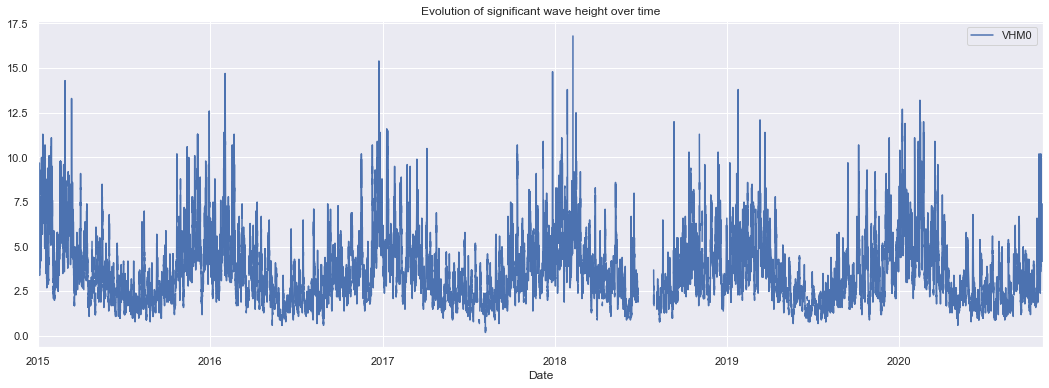

In [7]:
sns.set_theme(style="darkgrid")
data.plot(x="Date", y="VHM0", figsize=(18,6))
plt.title('Evolution of significant wave height over time')

<AxesSubplot:>

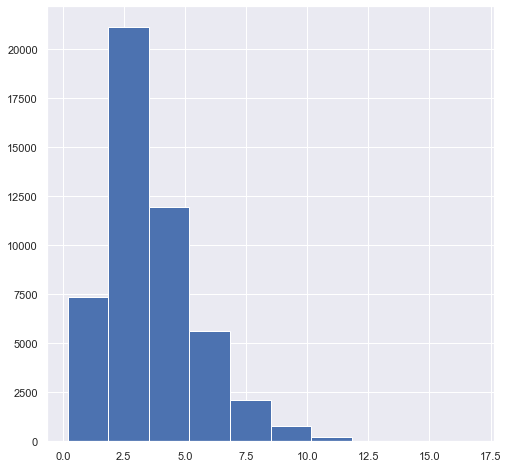

In [8]:
data["VHM0"].hist(figsize=(8,8))

Text(0.5, 1.0, 'Evolution of wind speed over time')

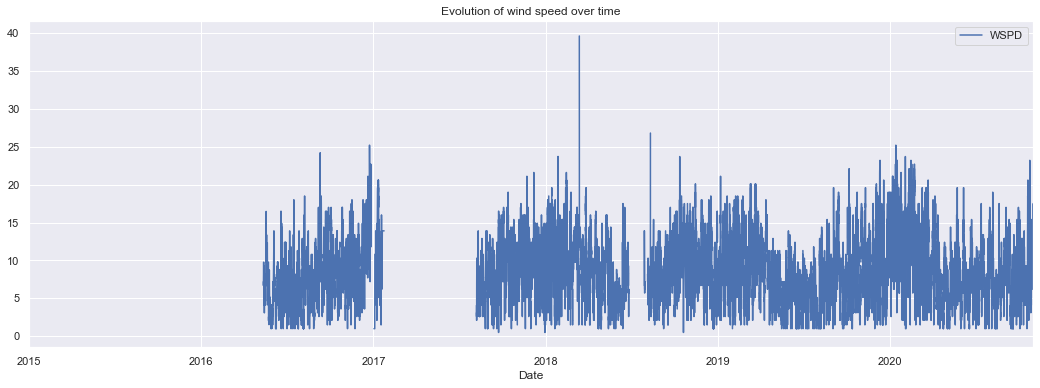

In [9]:
data.plot(x="Date", y="WSPD", figsize=(18,6))
plt.title('Evolution of wind speed over time')

<h2>We can observe that there's an extreme max value on <font color=blue>march 13th 2008</font> </h2>

In [10]:
data.loc[data[data["WSPD"] >30].index, "WSPD"] = np.nan

C:\Users\rafik\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [11]:
#verification that the observation was deleted
data.loc[data[data["WSPD"] >30].index, "WSPD"]

Series([], Name: WSPD, dtype: float64)

Text(0.5, 1.0, 'Evolution of wind speed over time')

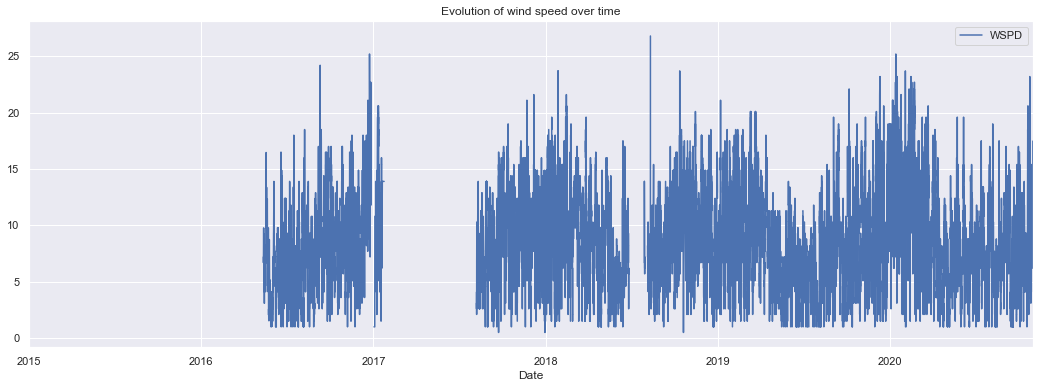

In [12]:
#We can see that the observations was deleted
data.plot(x="Date", y="WSPD", figsize=(18,6))
plt.title('Evolution of wind speed over time')

<h2> Data preparation</h2>

In [13]:
#We are gonna drop date because we don't need it now
data = data.drop("Date",axis=1)
data

,VHM0,WDIR,WSPD
TIME,,,
01/01/2015 00:00:00:000,4.9,NaN,NaN
01/01/2015 01:00:00:000,5.8,NaN,NaN
01/01/2015 02:00:00:000,6.0,NaN,NaN
01/01/2015 03:00:00:000,5.8,NaN,NaN
01/01/2015 04:00:00:000,5.8,NaN,NaN
...,...,...,...
31/10/2020 19:00:00:000,4.9,290.0,16.0
31/10/2020 20:00:00:000,4.5,270.0,12.4
31/10/2020 21:00:00:000,4.2,270.0,12.9


In [14]:
#Scale the data using minmax scaling
scaler = MinMaxScaler(feature_range=(0,1))
data = data.to_numpy()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=["VHM0","WDIR","WSPD"])
data

,VHM0,WDIR,WSPD
0,0.283133,NaN,NaN
1,0.337349,NaN,NaN
2,0.349398,NaN,NaN
3,0.337349,NaN,NaN
4,0.337349,NaN,NaN
...,...,...,...
51139,0.283133,0.800000,0.589354
51140,0.259036,0.742857,0.452471
51141,0.240964,0.742857,0.471483
51142,0.253012,0.714286,0.391635


<h2>In our model, we are gonna use the previous values of significant wave height measured to predict the next values</h2>

In [15]:
#you can specify the lag of the input and the output in the corresponding variables
lag_input = 5
lag_output = 7

<h3>The input and output of the seq2seq model must be three dimensionnal, reprsenting respectively:</h3>

1. the Samples
2. the time steps 
3. Features 

<h3>The next function is used to prepare and reshape data to be used in the model.</h3>

In [16]:
def data_prep(data, lag_input, lag_output, X_col, y_col):
    #data---type: numpy 2d array -----def: is the data used
    #lag_input---type: int-------def:  represent the the time steps of the inputs
    #lag_output---type: int------def:  represent the time steps of the outputs
    #X_col----type: list,--------def: represente the index of the columns used as input in the model
    #y_col----type: list,--------def: represente the index of the columns used as output in the model
    X_train = []
    y_train = []
    for i in range(lag_input, int(len(data)) - lag_output):
        X_train.append(data[i - lag_input:i, X_col])
        y_train.append(data[i:i + lag_output, y_col])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(X_col)))
    y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], len(y_col)))
    return [X_train, y_train]

In [17]:
#the time step used is 5 previous hours of data measured to predict the next 7 hours
X, y = data_prep(data.to_numpy(), lag_input = lag_input, lag_output = lag_output, X_col=[0,1,2], y_col=[0])

In [18]:
#Data verification
X

array([[[0.28313253,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.34939759,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan]],

       [[0.3373494 ,        nan,        nan],
        [0.34939759,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan]],

       [[0.34939759,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan],
        [0.3373494 ,        nan,        nan]],

       ...,

       [[0.25301205, 0.14285714, 0.45247148],
        [0.30722892, 0.14285714, 0.47148289],
        [0.28915663, 0.08571429, 0.45247148],
        [0.29518072, 1.        , 0.4904943 ],
        [0.28313253, 0.94285714, 0.5095057 ]],

       [[0.30722892, 0.14285714, 0.47148289],
        [0.28

In [19]:
#Data verification
y

array([[[0.3373494 ],
        [0.3373494 ],
        [0.31325301],
        ...,
        [0.31325301],
        [0.30722892],
        [0.31325301]],

       [[0.3373494 ],
        [0.31325301],
        [0.3253012 ],
        ...,
        [0.30722892],
        [0.31325301],
        [0.30722892]],

       [[0.31325301],
        [0.3253012 ],
        [0.31325301],
        ...,
        [0.31325301],
        [0.30722892],
        [0.31325301]],

       ...,

       [[0.27108434],
        [0.24698795],
        [0.24096386],
        ...,
        [0.26506024],
        [0.28313253],
        [0.25903614]],

       [[0.24698795],
        [0.24096386],
        [0.28313253],
        ...,
        [0.28313253],
        [0.25903614],
        [0.24096386]],

       [[0.24096386],
        [0.28313253],
        [0.26506024],
        ...,
        [0.25903614],
        [0.24096386],
        [0.25301205]]])

In [20]:
#Determine where there's a nan value in input or output (if any of [x1, x2, ...] == nan np.isnan == True)
x_nan_index = np.isnan(X).any(axis=1)
#create and initiate a new variable called x_nan_index_all to get the index of the rows where there's any nan value 
x_nan_index_all = x_nan_index[:,0] | x_nan_index[:,1]
#loop through all columns
for col_num in range(1,x_nan_index.shape[1]):
    x_nan_index_all = x_nan_index_all | x_nan_index[:,col_num]
#get the index of rows where's nan values in the "y" numpy array
y_nan_index = np.isnan(y).any(axis=1)
#Apply the OR operation on the two index
train_index = x_nan_index_all | y_nan_index[:,0]
#Get the values or vectors where's there's no nan values
X = X[~train_index]
y = y[~train_index]

In [21]:
#Data verification
X

array([[[0.06626506, 0.08571429, 0.2548289 ],
        [0.06626506, 0.14285714, 0.23524715],
        [0.06626506, 0.14285714, 0.23524715],
        [0.06024096, 0.08571429, 0.2548289 ],
        [0.06626506, 0.08571429, 0.2548289 ]],

       [[0.06626506, 0.14285714, 0.23524715],
        [0.06626506, 0.14285714, 0.23524715],
        [0.06024096, 0.08571429, 0.2548289 ],
        [0.06626506, 0.08571429, 0.2548289 ],
        [0.07228916, 0.08571429, 0.27437262]],

       [[0.06626506, 0.14285714, 0.23524715],
        [0.06024096, 0.08571429, 0.2548289 ],
        [0.06626506, 0.08571429, 0.2548289 ],
        [0.07228916, 0.08571429, 0.27437262],
        [0.07831325, 0.14285714, 0.29395437]],

       ...,

       [[0.25301205, 0.14285714, 0.45247148],
        [0.30722892, 0.14285714, 0.47148289],
        [0.28915663, 0.08571429, 0.45247148],
        [0.29518072, 1.        , 0.4904943 ],
        [0.28313253, 0.94285714, 0.5095057 ]],

       [[0.30722892, 0.14285714, 0.47148289],
        [0.28

In [22]:
#Data verification
y

array([[[0.07228916],
        [0.07831325],
        [0.07831325],
        ...,
        [0.08433735],
        [0.10843373],
        [0.11445783]],

       [[0.07831325],
        [0.07831325],
        [0.07831325],
        ...,
        [0.10843373],
        [0.11445783],
        [0.13253012]],

       [[0.07831325],
        [0.07831325],
        [0.08433735],
        ...,
        [0.11445783],
        [0.13253012],
        [0.14457831]],

       ...,

       [[0.27108434],
        [0.24698795],
        [0.24096386],
        ...,
        [0.26506024],
        [0.28313253],
        [0.25903614]],

       [[0.24698795],
        [0.24096386],
        [0.28313253],
        ...,
        [0.28313253],
        [0.25903614],
        [0.24096386]],

       [[0.24096386],
        [0.28313253],
        [0.26506024],
        ...,
        [0.25903614],
        [0.24096386],
        [0.25301205]]])

In [23]:
#Now we split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)

In [24]:
#Data verification
X_train.shape

(19767, 5, 3)

In [25]:
#Data verification
y_train.shape

(19767, 7, 1)

<h1><center>Modeling using seq2seq Architecture</center></h1>

<img src="https://www.researchgate.net/profile/Ryan-Mcclarren2/publication/328953162/figure/fig1/AS:693075290640384@1542253434724/Unrolled-seq2seq-architecture-The-blue-and-red-cells-represent-stacks-of-recurrent-cells_W640.jpg" alt="LSTM model image" title="" />

<h3> <center>In the next cells, we are gonna create and train out seq2seq model and check its performance</center></h3>
<h4> We would like to point out that the architecture of the model is not optimized, and there's overfitting that can be avoided by analyzing more efficiently the data and maybe split the train, validation, and test datasets manually</h4>

In [26]:
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model, model_to_dot

In [27]:
#the number of hidden unit in the LSTM layer of the encoder part
n_hidden = 8

In [39]:

#create the input and the output layers
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))

#-----------------------------ENCODER PART -----------------------------------------------

#get the hidden and the cell state of the last cell of the LSTM layer
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

#include a batch normalization layer to avoid overfitting
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

#---------------------------------- DECODER PART --------------------------------------------------

#repeat the values of the hidden state to input-it in the LSTM layer of the encoder part
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

#apply the dense network on the outputs of the LSTM layer to get the final outputs of the model 
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

In [40]:
#create the model and assign the input and output data
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
#compile the model with the different parameters
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5, 3)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 8), (None, 8 384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 8)            32          lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 7, 8)         0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

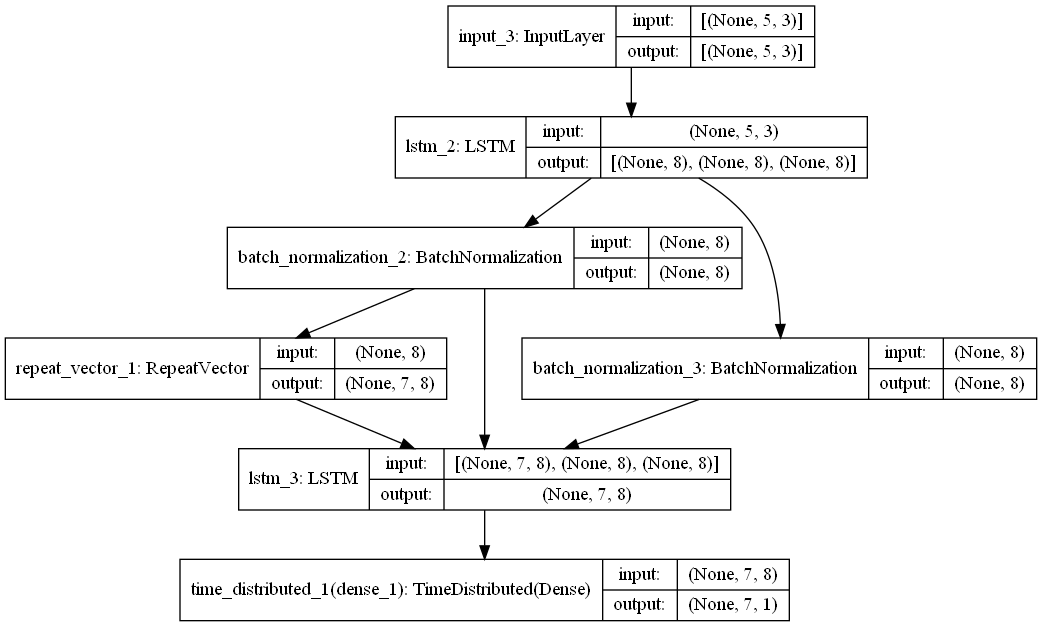

In [41]:
#print the model structure
#you will need to install graphviz from official website and install pydot via pip
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
#assign the number of epoch
epc = 200
#add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = model.fit(X_train, y_train, validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=1000)

train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/200
16/16 [==============================] - 5s 41ms/step - loss: 0.0942 - mae: 0.2271 - val_loss: 0.0068 - val_mae: 0.0636
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0137 - mae: 0.0883 - val_loss: 0.0027 - val_mae: 0.0364
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0074 - mae: 0.0643 - val_loss: 0.0020 - val_mae: 0.0328
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0052 - mae: 0.0538 - val_loss: 0.0018 - val_mae: 0.0310
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mae: 0.0492 - val_loss: 0.0016 - val_mae: 0.0268
Epoch 6/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0456 - val_loss: 0.0016 - val_mae: 0.0277
Epoch 7/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0015 - val_mae: 0.0273
Epoch 8/200
16/16 [==============================] - ETA: 0s - loss: 0.0031 

16/16 [==============================] - 0s 12ms/step - loss: 0.0017 - mae: 0.0283 - val_loss: 0.0017 - val_mae: 0.0254
Epoch 63/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0281 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 64/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0020 - val_mae: 0.0275
Epoch 65/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0234
Epoch 66/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0015 - val_mae: 0.0238
Epoch 67/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0281 - val_loss: 0.0018 - val_mae: 0.0259
Epoch 68/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0022 - val_mae: 0.0299
Epoch 69/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0016 

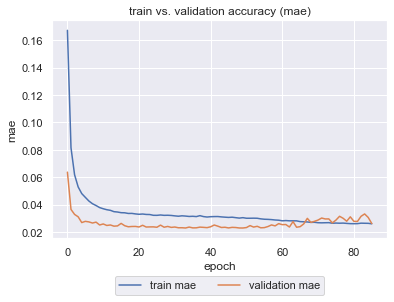

In [43]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

<h2><center>Results of the Training Period</center></h2>

In [44]:
#get the result of the application of the model in the training period
train_preds = model.predict(X_train, verbose=2)
#reshape the variable to be more understandable
train_preds = train_preds.reshape(y_train.shape[0], lag_output)
#get and reshape the observed values
train_obs = y_train.reshape(y_train.shape[0], lag_output)

618/618 - 1s


In [45]:
#print the result of the prediction on each time steps

#get the range of VHM0 for RMSE
RMSE_factor = max(rawdata["VHM0"].dropna()) - min(rawdata["VHM0"].dropna()) 

print('Results of the Training period \n')
for i in range(1,lag_output+1):
    print("RMSE for the", i, "hour (m): %f" % (np.sqrt(mean_squared_error(train_obs[:, i-1], train_preds[:, i-1]))*RMSE_factor))
    print("R² for the", i, "hour : %f" % r2_score(train_obs[:,i-1], train_preds[:,i-1]), "\n")

Results of the Training period 

RMSE for the 1 hour (m): 0.427541
R² for the 1 hour : 0.942948 

RMSE for the 2 hour (m): 0.525351
R² for the 2 hour : 0.913806 

RMSE for the 3 hour (m): 0.613670
R² for the 3 hour : 0.882890 

RMSE for the 4 hour (m): 0.687898
R² for the 4 hour : 0.852633 

RMSE for the 5 hour (m): 0.754216
R² for the 5 hour : 0.822854 

RMSE for the 6 hour (m): 0.811179
R² for the 6 hour : 0.795142 

RMSE for the 7 hour (m): 0.858788
R² for the 7 hour : 0.769785 



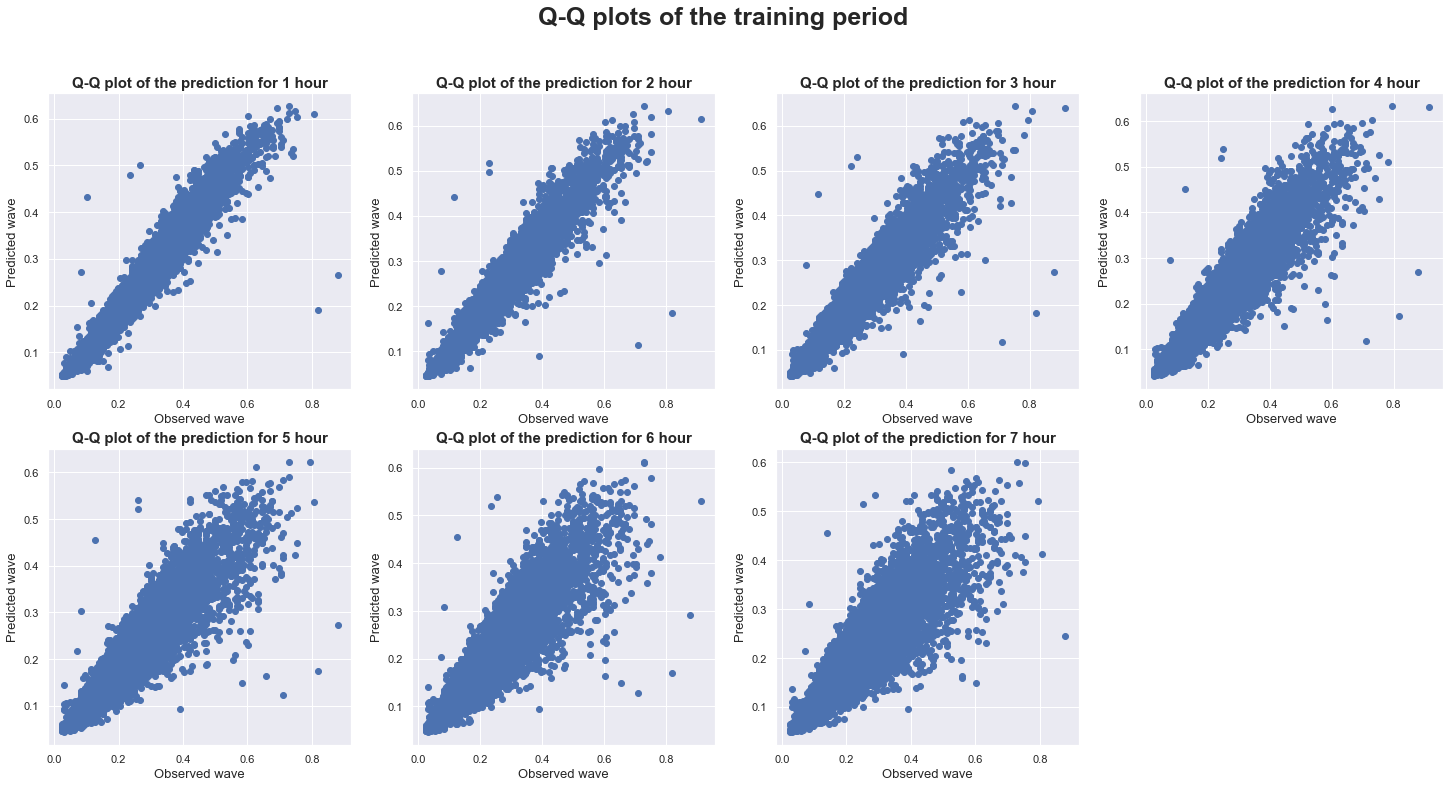

In [46]:
#Print the Q-Q plots of the results for the different time steps

#I choose to print 4 columns of subplots and adapt the number of rows based on the length of the time step prediction
fig, axs = plt.subplots(round(lag_output/4), 4, figsize=(25,12))
#Title
fig.suptitle('Q-Q plots of the training period', fontweight="bold", size=25)
#initiate a variable that count the number of subplots plotted
plot_index = 0
for row in range(round(lag_output/4)):
    for col in range(4):
        if plot_index < lag_output:
            #parameters of the subplot
            axs[row, col].set_title("Q-Q plot of the prediction for " + str(plot_index+1) + " hour", size=15, fontweight="bold")
            axs[row, col].scatter(train_obs[:, plot_index], train_preds[:, plot_index])
            axs[row, col].set_ylabel('Predicted wave', fontsize = 13)
            axs[row, col].set_xlabel('Observed wave', fontsize = 13)
            plot_index +=1
        else:
            #Delete the subplot if the variable "plot_index" exceed the time step length
            fig.delaxes(axs[row, col])

<h2><center>Results of the Testing Period</center></h2>

In [47]:
#print the result of the prediction on each time steps
test_preds = model.predict(X_test, verbose=2)
#reshape the variable to be more understandable
test_preds = test_preds.reshape(y_test.shape[0], lag_output)
#get and reshape the observed values
test_obs = y_test.reshape(y_test.shape[0], lag_output)

305/305 - 0s


In [48]:
#print the result of the prediction on each time steps

#get the amplitud of VHM0 for RMSE
RMSE_factor = max(rawdata["VHM0"].dropna()) - min(rawdata["VHM0"].dropna())
print('Results of the Testing period \n')
for i in range(1, lag_output+1):
    print("RMSE for the : %f" % (np.sqrt(mean_squared_error(test_obs[:, i-1], test_preds[:, i-1]))*RMSE_factor))
    print("R² for the", i, "hour : %f" % r2_score(test_obs[:,i-1], test_preds[:,i-1]), "\n")

Results of the Testing period 

RMSE for the : 0.431085
R² for the 1 hour : 0.941089 

RMSE for the : 0.521069
R² for the 2 hour : 0.914200 

RMSE for the : 0.586234
R² for the 3 hour : 0.890588 

RMSE for the : 0.667683
R² for the 4 hour : 0.858863 

RMSE for the : 0.735159
R² for the 5 hour : 0.829122 

RMSE for the : 0.800386
R² for the 6 hour : 0.798203 

RMSE for the : 0.872313
R² for the 7 hour : 0.763064 



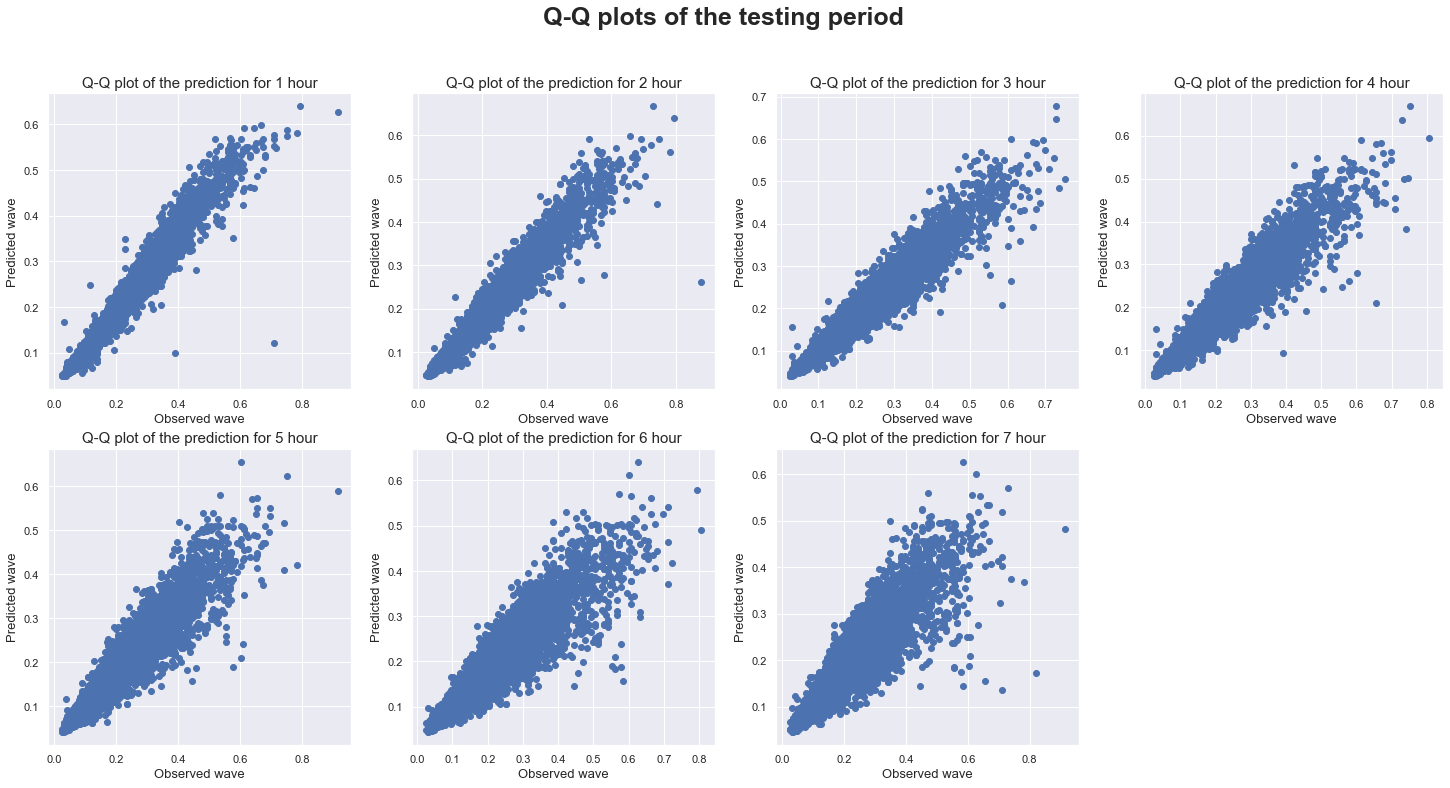

In [49]:
#Print the Q-Q plots of the results for the different time steps

#I choose to print 4 columns of subplots and adapt the number of rows based on the length of the time step prediction
fig, axs = plt.subplots(round(lag_output/4), 4, figsize=(25,12))
#Title
fig.suptitle('Q-Q plots of the testing period', fontweight="bold", size=25)
#initiate a variable that count the number of subplots plotted
plot_index = 0
for row in range(round(lag_output/4)):
    for col in range(4):
        if plot_index < lag_output:
            #parameters of the subplot
            axs[row, col].set_title("Q-Q plot of the prediction for " + str(plot_index+1) + " hour", size=15)
            axs[row, col].scatter(test_obs[:, plot_index], test_preds[:, plot_index])
            axs[row, col].set_ylabel('Predicted wave', fontsize = 13)
            axs[row, col].set_xlabel('Observed wave', fontsize = 13)
            plot_index +=1
        else:
            #Delete the subplot if the variable "plot_index" exceed the time step length
            fig.delaxes(axs[row, col])